# Hierarchical Parity Model

This Jupyter notebook uses the Python library Jax to exactly compute various thermodynamic quantities for the disordered Hierarchical Parity Model.

In [1]:
## imports
import time
import scipy
from scipy.stats import sem
import os
from collections import Counter
import seaborn as sns

## Jax/Numpy
#os.environ["LD_LIBRARY_PATH"]="/usr/lib/x86_64-linux-gnu/" #this is where the libcudnn.so file resides
#os.environ["JAX_PLATFORM_NAME"] = "cpu"

import numpy as onp #o for "old" or "original"
import jax.numpy as np
import jax
from jax import grad, jit, lax, random, ops, vmap, jacfwd, jacrev, device_get, device_put
from jax.scipy.special import logsumexp
from jax.lib import xla_bridge

from utils import *

jax version 0.3.7
jax backend gpu


In [2]:
## matplotlib settings
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.style.use('ggplot')

plt.rcParams['font.size'] = '14'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Computer Modern']

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams["axes.edgecolor"] = "black"

plt.rcParams['text.color'] = 'k'
plt.rcParams['axes.labelcolor'] = 'k'
plt.rcParams['xtick.color'] = 'k'
plt.rcParams['ytick.color'] = 'k'

plt.rcParams['xtick.major.size'] = 15
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 15
plt.rcParams['ytick.major.width'] = 1

plt.rcParams['xtick.minor.size'] = 7
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.size'] = 7
plt.rcParams['ytick.minor.width'] = 1
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Dictionary-Based (Non-Auto-Diff) Code

This code is based on using dictionaries, it's much faster than than the Jax code but doesn't allow for derivatives to be computed. 

In [3]:
n = 12
print('N = %i spins' %(2**n))
beta = 2.0

N = 4096 spins


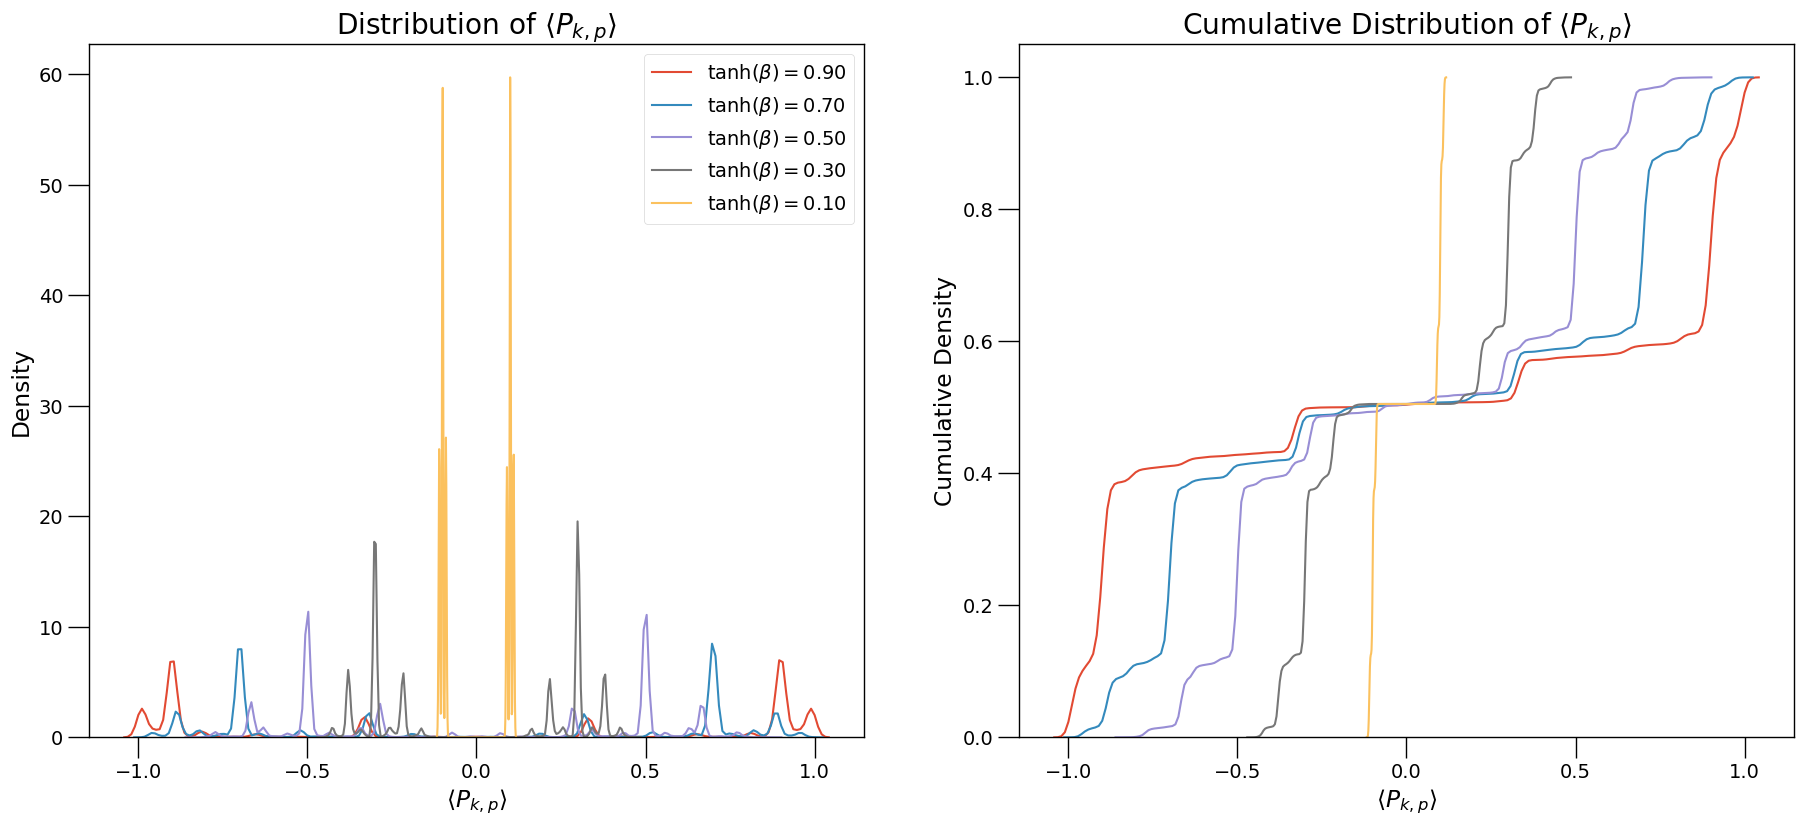

In [4]:
couplings = generate_couplings_dic(n)
th_beta_list = np.flip(np.linspace(0.1, 0.9, 5))

fig, ax = plt.subplots(1, 2, figsize=(2*11,9))
for i in range(len(th_beta_list)):
    beta = np.arctanh(th_beta_list[i])
    parities = find_parities_dic(beta, couplings)
    
    #ax[0].hist(list(parities.values()), bins=100, label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i])
    sns.kdeplot(list(parities.values()), label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i], ax=ax[0], bw_adjust=.1)
    #sns.histplot(list(parities.values()), color=colors[i], label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i], ax=ax[0])
    ax[0].legend()
    ax[0].set_title(r"Distribution of $\langle P_{k,p} \rangle$")
    ax[0].set_xlabel(r'$\langle P_{k,p} \rangle$')
    ax[1].set_ylabel('Density')
    
    sns.kdeplot(list(parities.values()), label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i], ax=ax[1], bw_adjust=.1, cumulative=True)
    #ax[1].legend()
    ax[1].set_title(r"Cumulative Distribution of $\langle P_{k,p} \rangle$")
    ax[1].set_xlabel(r'$\langle P_{k,p} \rangle$')
    ax[1].set_ylabel('Cumulative Density')
    
plt.savefig('figures/disordered_model_parity_distribution.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Does anything interesting happen as we cross the Nishimori line:

N = 4096 spins
Nishimori tanh(beta) = 0.40


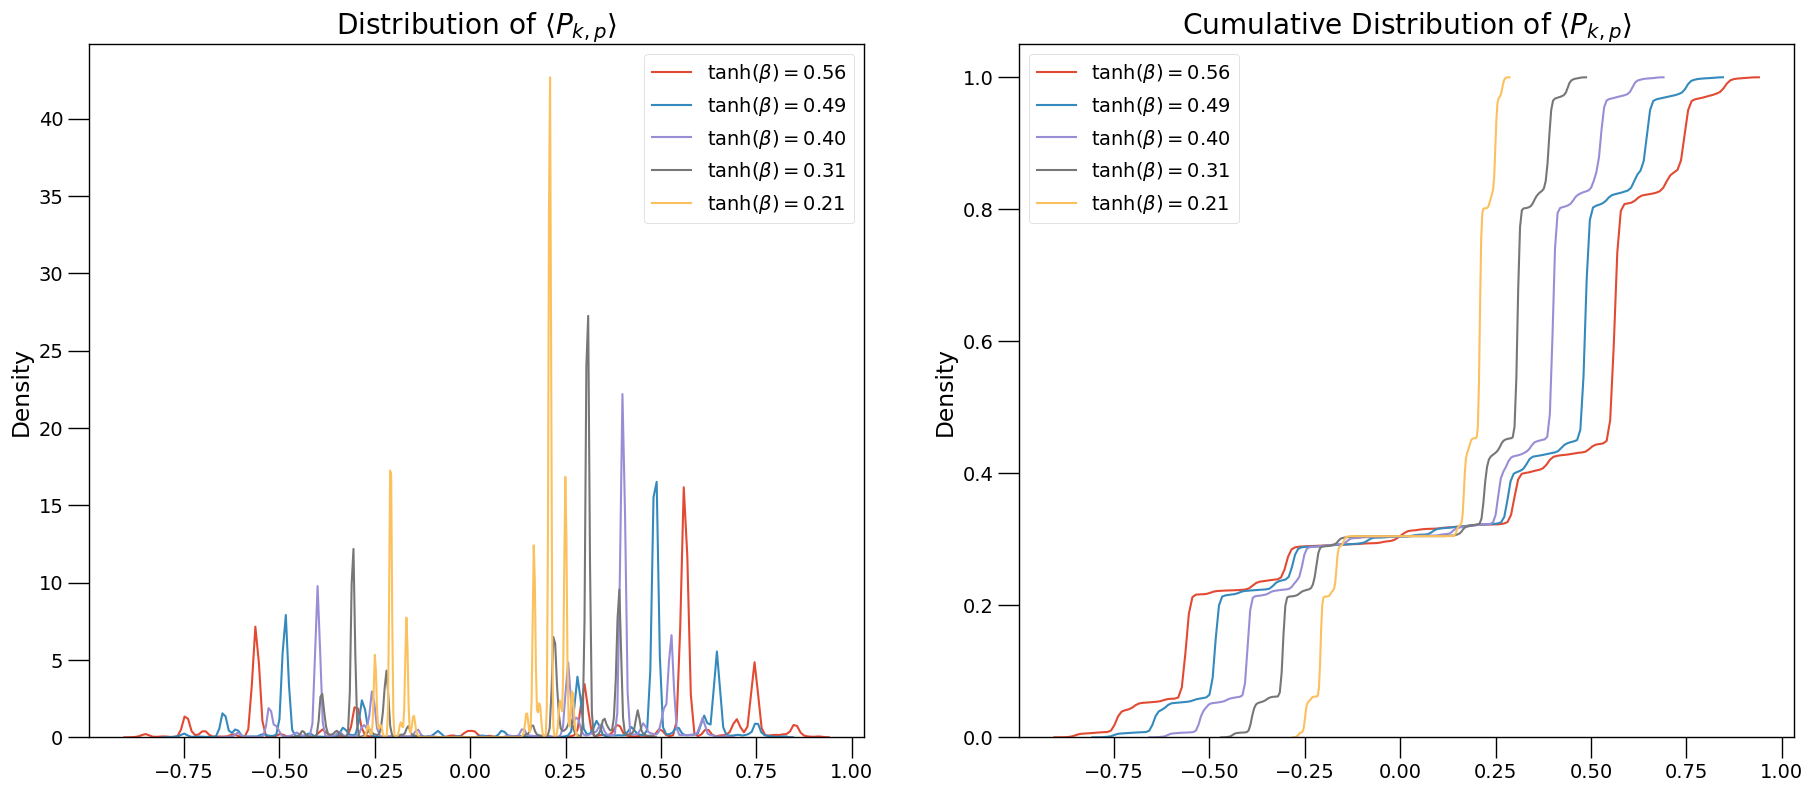

In [5]:
n = 12
prob = 0.7
sigma = 0
print('N = %i spins' %(2**n))

couplings = generate_couplings_dic(n, prob=prob, sigma=sigma)
beta_N = Nishimorhi_beta(prob)
print('Nishimori tanh(beta) = %.2f' %np.tanh(beta_N))

beta_list = np.flip(np.linspace(0.5, 1.5, 5)*beta_N)
th_beta_list = np.tanh(beta_list)

fig, ax = plt.subplots(1, 2, figsize=(2*11,9))
for i in range(len(th_beta_list)):
    beta = np.arctanh(th_beta_list[i])
    parities = find_parities_dic(beta, couplings)
    
    #ax.hist(list(parities.values()), bins=100, label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i])
    sns.kdeplot(list(parities.values()), label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i], ax=ax[0], bw_adjust=.1)
    #sns.histplot(list(parities.values()), color='red', label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i], ax=ax)
    ax[0].legend()
    ax[0].set_title(r"Distribution of $\langle P_{k,p} \rangle$")

    sns.kdeplot(list(parities.values()), label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i], ax=ax[1], bw_adjust=.1, cumulative=True)
    ax[1].legend()
    ax[1].set_title(r"Cumulative Distribution of $\langle P_{k,p} \rangle$")

plt.show()

What about when we vary $\sigma$?

N = 1024 spins


/home/gavin/Dropbox/Research/Machine Learning/Google Collaboration/hierarchical/utils.py:53: RuntimeWarning: invalid value encountered in float_scalars
  parities[k,p] /= (onp.cosh(betaJ) + onp.sinh(betaJ)*parities[k-1,2*p-1]*parities[k-1,2*p])


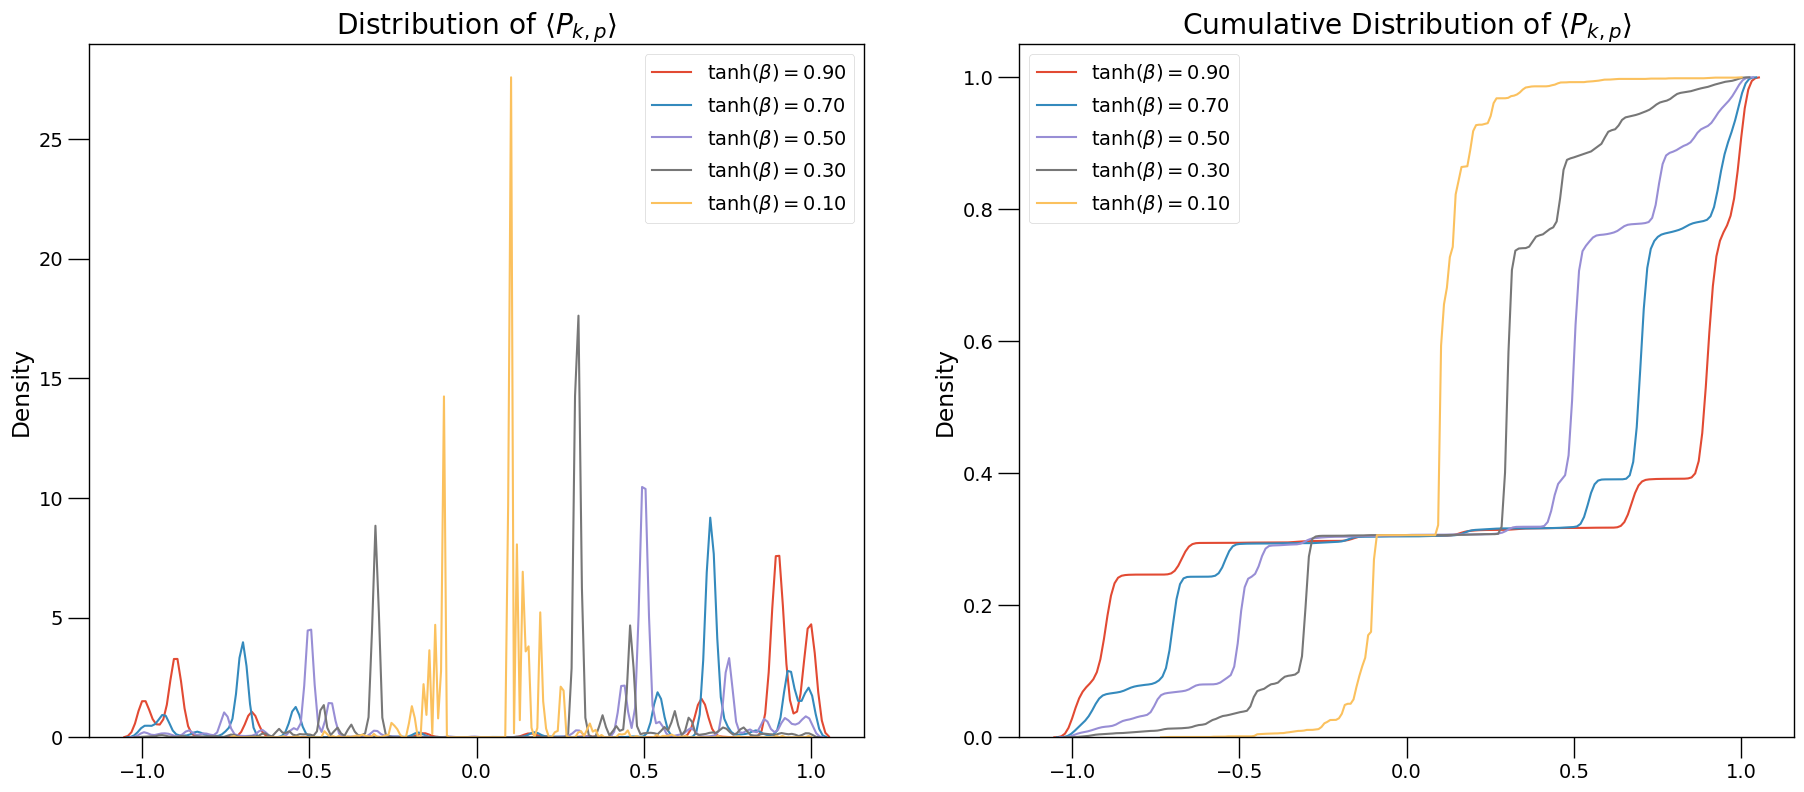

In [6]:
n = 10
prob = 0.7
sigma = 0.4
print('N = %i spins' %(2**n))

couplings = generate_couplings_dic(n, prob=prob, sigma=sigma)
th_beta_list = np.flip(np.linspace(0.1, 0.9, 5))

fig, ax = plt.subplots(1, 2, figsize=(2*11,9))
for i in range(len(th_beta_list)):
    beta = np.arctanh(th_beta_list[i])
    parities = find_parities_dic(beta, couplings)
    
    #ax[0].hist(list(parities.values()), bins=100, label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i])
    sns.kdeplot(list(parities.values()), label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i], ax=ax[0], bw_adjust=.1)
    #sns.histplot(list(parities.values()), color=colors[i], label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i], ax=ax[0])
    ax[0].legend()
    ax[0].set_title(r"Distribution of $\langle P_{k,p} \rangle$")

    sns.kdeplot(list(parities.values()), label=r'$\tanh(\beta) = %.2f$' %th_beta_list[i], ax=ax[1], bw_adjust=.1, cumulative=True)
    ax[1].legend()
    ax[1].set_title(r"Cumulative Distribution of $\langle P_{k,p} \rangle$")

plt.show()

## Jax Auto-Diff Code

The goal was to code this up in Jax so that I could compute arbitrary correlation functions using the differentiability of the partition function. Unfortunately, the ops.index_update function is very slow, meaning that it's hard to get beyond moderate system sizes.

In [7]:
n = 6
beta = 1.2
sigma = 0.3
prob = 0.5
print('N = %i spins' %(2**n))

couplings = generate_couplings(n, prob=prob, sigma=sigma)
parities = find_parities(beta, couplings)

log_partition_function(beta, couplings);

N = 64 spins


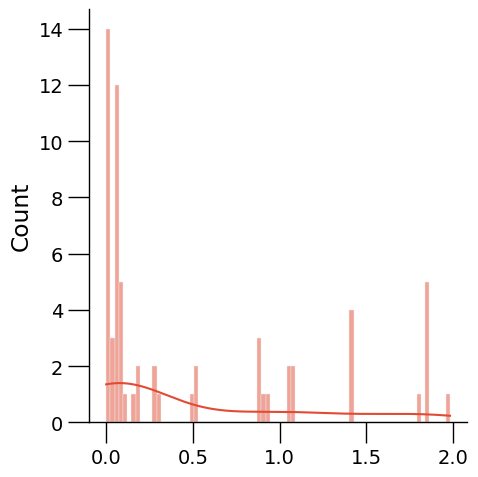

In [8]:
sns.displot(onp.real(onp.linalg.eig(chi_ij(beta, couplings))[0]), bins=82, kde=True)
plt.show()

### inspect convergence as thermodynamic limit is approached

In [ ]:
n_disorder = 100
n_list = [i for i in range(3,10)]

th_beta_list = np.flip(np.linspace(0.05, 0.95, 20))
sigma = 0.0
prob = 0.5

f_list = onp.zeros((len(n_list), n_disorder, len(th_beta_list)))
e_list = onp.zeros((len(n_list), n_disorder, len(th_beta_list)))
s_list = onp.zeros((len(n_list), n_disorder, len(th_beta_list)))
c_list = onp.zeros((len(n_list), n_disorder, len(th_beta_list)))
#chi_list = onp.zeros((len(n_list), n_disorder, len(th_beta_list)))

## loop over different system sizes
for i_n in range(len(n_list)):
    n = n_list[i_n]
    N = 2**n
    print('processing n = %i' %n)
    
    ## loop over disorder replicas
    for i in range(n_disorder):
        couplings = generate_couplings(n, prob=prob, sigma=sigma)
        
        ## loop over temperatures
        for j in range(len(th_beta_list)):
            beta = np.arctanh(th_beta_list[j])
            
            f_list[i_n, i, j] = free_energy(beta, couplings).item()/N
            e_list[i_n, i, j] = energy(beta, couplings).item()/N
            s_list[i_n, i, j] = entropy(beta, couplings).item()/N
            c_list[i_n, i, j] = specific_heat(beta, couplings).item()/N
            #chi_list[i_n, i, j] = chi_SG(beta, couplings).item()

In [ ]:
# modify above PDF to histogram

In [ ]:
## free energy
for i_n in range(len(n_list)):
    #ax[0].plot(th_beta_list, np.mean(f_list[i_n], axis=0), label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))
    ax[0].errorbar(th_beta_list, np.mean(f_list[i_n], axis=0), 1.96*sem(f_list[i_n], axis=0), fmt='--o', \
                   label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))
ax[0].set_xlabel(r'$\tanh(\beta)$')
ax[0].set_title(r'Free Energy Density $F/N$')
#ax[0].set_ylabel(r'$f$')
ax[0].legend()

In [ ]:
f_list.shape

In [ ]:
for i_n in range(len(n_list)):
    plt.plot(th_beta_list, np.mean(f_list[i_n], axis=0))
plt.show()

In [ ]:
th_beta_list.shape, f_list.shape

In [ ]:
for i_n in range(len(n_list)-1):
    plt.plot(th_beta_list, (np.mean(f_list, axis=1)[i_n+1] - np.mean(f_list, axis=1)[i_n])/np.mean(f_list, axis=1)[i_n], 
             label=r'$\epsilon_{%i,%i}$' %(i_n+1,i_n))
    plt.legend()
plt.show()

In [ ]:
for i_n in range(len(n_list)-1):
    plt.plot(th_beta_list, (np.mean(c_list, axis=1)[i_n+1] - np.mean(c_list, axis=1)[i_n])/np.mean(c_list, axis=1)[i_n], 
             label=r'$\epsilon_{%i,%i}$' %(i_n+1,i_n))
    plt.legend()
plt.show()

In [ ]:
for i_n in range(len(n_list)-1):
    plt.plot(th_beta_list, np.mean(f_list, axis=1)[i_n+1] - np.mean(f_list, axis=1)[i_n], label=r'$\epsilon_{%i,%i}$' %(i_n+1,i_n))
    plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(2*11,2*9))
ax = ax.flatten()

## free energy
for i_n in range(len(n_list)):
    #ax[0].plot(th_beta_list, np.mean(f_list[i_n], axis=0), label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))
    ax[0].errorbar(th_beta_list, np.mean(f_list[i_n], axis=0), 1.96*sem(f_list[i_n], axis=0), fmt='--o', \
                   label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))
ax[0].set_xlabel(r'$\tanh(\beta)$')
ax[0].set_title(r'Free Energy Density $F/N$')
#ax[0].set_ylabel(r'$f$')
ax[0].legend()

## energy
for i_n in range(len(n_list)):
    #ax[1].plot(th_beta_list, np.mean(e_list[i_n], axis=0), label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))
    ax[1].errorbar(th_beta_list, np.mean(e_list[i_n], axis=0), 1.96*sem(e_list[i_n], axis=0), fmt='--o', \
                   label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))    
ax[1].set_xlabel(r'$\tanh(\beta)$')
ax[1].set_title(r'Energy Density $\langle E\rangle/N$')
#ax[1].set_ylabel(r'$f$')
#ax[1].legend()

## entropy
for i_n in range(len(n_list)):
#    ax[2].plot(th_beta_list, np.mean(s_list[i_n], axis=0), label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))
    ax[2].errorbar(th_beta_list, np.mean(s_list[i_n], axis=0), 1.96*sem(s_list[i_n], axis=0), fmt='--o', \
                   label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))    
ax[2].set_xlabel(r'$\tanh(\beta)$')
ax[2].set_title(r'Entropy Density $S/N$')
#ax[1].legend()

for i_n in range(len(n_list)):
#    ax[3].plot(th_beta_list, np.mean(c_list[i_n], axis=0), label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))
    ax[3].errorbar(th_beta_list, np.mean(c_list[i_n], axis=0), 1.96*sem(c_list[i_n], axis=0), fmt='--o', \
                   label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))   
ax[3].set_xlabel(r'$\tanh(\beta)$')
ax[3].set_title(r'Specific Heat Density $C/N$')

'''
for i_n in range(len(n_list)):
    ax[4].errorbar(th_beta_list, np.mean(chi_list[i_n], axis=0), 1.96*sem(chi_list[i_n], axis=0), fmt='--o', \
                   label=r'$n = %i\, (N = %i)$'%(n_list[i_n], 2**n_list[i_n]))   
ax[4].set_xlabel(r'$\tanh(\beta)$')
ax[4].set_title(r'$\chi_{SG}$')
'''

## make sure the x tick marks extend to 1.0
for i in range(len(ax)):
    ax[i].xaxis.set_ticks(np.arange(0, 1.2, 0.2))

plt.savefig('figures/disordered_model_thermodynamics.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

### scan over disorder parameter space $(\sigma, p)$

In [245]:
def process_data(data, sigma=1):
    x = []
    y = []
    z = []
    
    ## perform the disorder average
    data = np.mean(data, axis=0)

    ## perform gaussian smoothing to make nicer plots
    ## the motivation for this came from this SE post: 
    ## https://stackoverflow.com/questions/12274529/how-to-smooth-matplotlib-contour-plot
    data = scipy.ndimage.gaussian_filter(data, sigma)
    
    ## extract each individual point and add it to a list
    for j in range(len(prob_list)):
        for i in range(len(th_beta_list)):
            x.append(th_beta_list[i])
            y.append(prob_list[j])
            z.append(data[i,j])
    x = np.asarray(x)
    y = np.asarray(y)
    z = np.asarray(z)
    
    return x, y, z

In [ ]:
n_grid = 100
n_disorder = 100
n = 8
sigma = 0.0

prob_list = np.linspace(0.05, 0.95, n_grid)
th_beta_list = np.linspace(0.05, 0.95, n_grid)
print('system size: N = %i, state space size = %.2e' % (2**n, 2**(2**n)))

f_list = onp.zeros((n_disorder, len(th_beta_list), len(prob_list)))
e_list = onp.zeros((n_disorder, len(th_beta_list), len(prob_list)))
s_list = onp.zeros((n_disorder, len(th_beta_list), len(prob_list)))
c_list = onp.zeros((n_disorder, len(th_beta_list), len(prob_list)))

## loop over p values
counter = 0
t = time.time()
for i_p in range(len(prob_list)):
    prob = prob_list[i_p]
    
    ## loop over disorder replicas
    for k in range(n_disorder):
        couplings = generate_couplings(n, prob=prob, sigma=sigma)
        
        ## loop over temperatures
        for i_T in range(len(th_beta_list)):
            beta = np.arctanh(th_beta_list[i_T])
            
            f_list[k, i_T, i_p] = free_energy(beta, couplings).item()/2**n
            e_list[k, i_T, i_p] = energy(beta, couplings).item()/2**n
            s_list[k, i_T, i_p] = entropy(beta, couplings).item()/2**n
            c_list[k, i_T, i_p] = specific_heat(beta, couplings).item()/2**n
            
    print('iter %i/%i | time elapsed = %.2f s | prob = %.2f' %(counter, len(prob_list), time.time() - t, prob))
    counter += 1
    t = time.time()

system size: N = 256, state space size = 1.16e+77
iter 0/100 | time elapsed = 879.80 s | prob = 0.05
iter 1/100 | time elapsed = 140.20 s | prob = 0.06
iter 2/100 | time elapsed = 140.41 s | prob = 0.07
iter 3/100 | time elapsed = 140.56 s | prob = 0.08
iter 4/100 | time elapsed = 140.10 s | prob = 0.09
iter 5/100 | time elapsed = 140.12 s | prob = 0.10
iter 6/100 | time elapsed = 140.33 s | prob = 0.10
iter 7/100 | time elapsed = 140.26 s | prob = 0.11
iter 8/100 | time elapsed = 140.40 s | prob = 0.12
iter 9/100 | time elapsed = 140.31 s | prob = 0.13
iter 10/100 | time elapsed = 140.19 s | prob = 0.14
iter 11/100 | time elapsed = 140.43 s | prob = 0.15
iter 12/100 | time elapsed = 140.57 s | prob = 0.16
iter 13/100 | time elapsed = 140.34 s | prob = 0.17
iter 14/100 | time elapsed = 140.16 s | prob = 0.18
iter 15/100 | time elapsed = 140.01 s | prob = 0.19
iter 16/100 | time elapsed = 140.30 s | prob = 0.20
iter 17/100 | time elapsed = 140.61 s | prob = 0.20
iter 18/100 | time elaps

In [ ]:
## consider saving the results
## make a repo

process the data by making mesh grids:

In [261]:
data_list = [f_list, e_list, s_list, c_list]
title_list = ['Free Energy density', 'Energy density', 'Entropy density', 'Specific Heat density']

## process the data
z_list = []
zi_list = []
for i in range(4):
    ## grab the data and arrange it into lists
    x, y, z = process_data(data_list[i], sigma=2)
    z_list.append(z)
    
    ## set up a regular grid of interpolation points    
    ## use the same grid for all thermodynamic quantities
    if i == 0:
        ## original grid
        #xi = x.reshape((n_grid, n_grid))
        #yi = y.reshape((n_grid, n_grid))
        
        ## interpolated grid (smoother)
        n_grid2 = 20
        xi, yi = np.linspace(x.min(), x.max(), n_grid2), np.linspace(y.min(), y.max(), n_grid2)
        xi, yi = np.meshgrid(xi, yi)

    zi = scipy.interpolate.Rbf(x, y, z, function='linear')(xi, yi)
    #zi = z.reshape((n_grid, n_grid))
    zi_list.append(zi)

Make 3d surface plots:

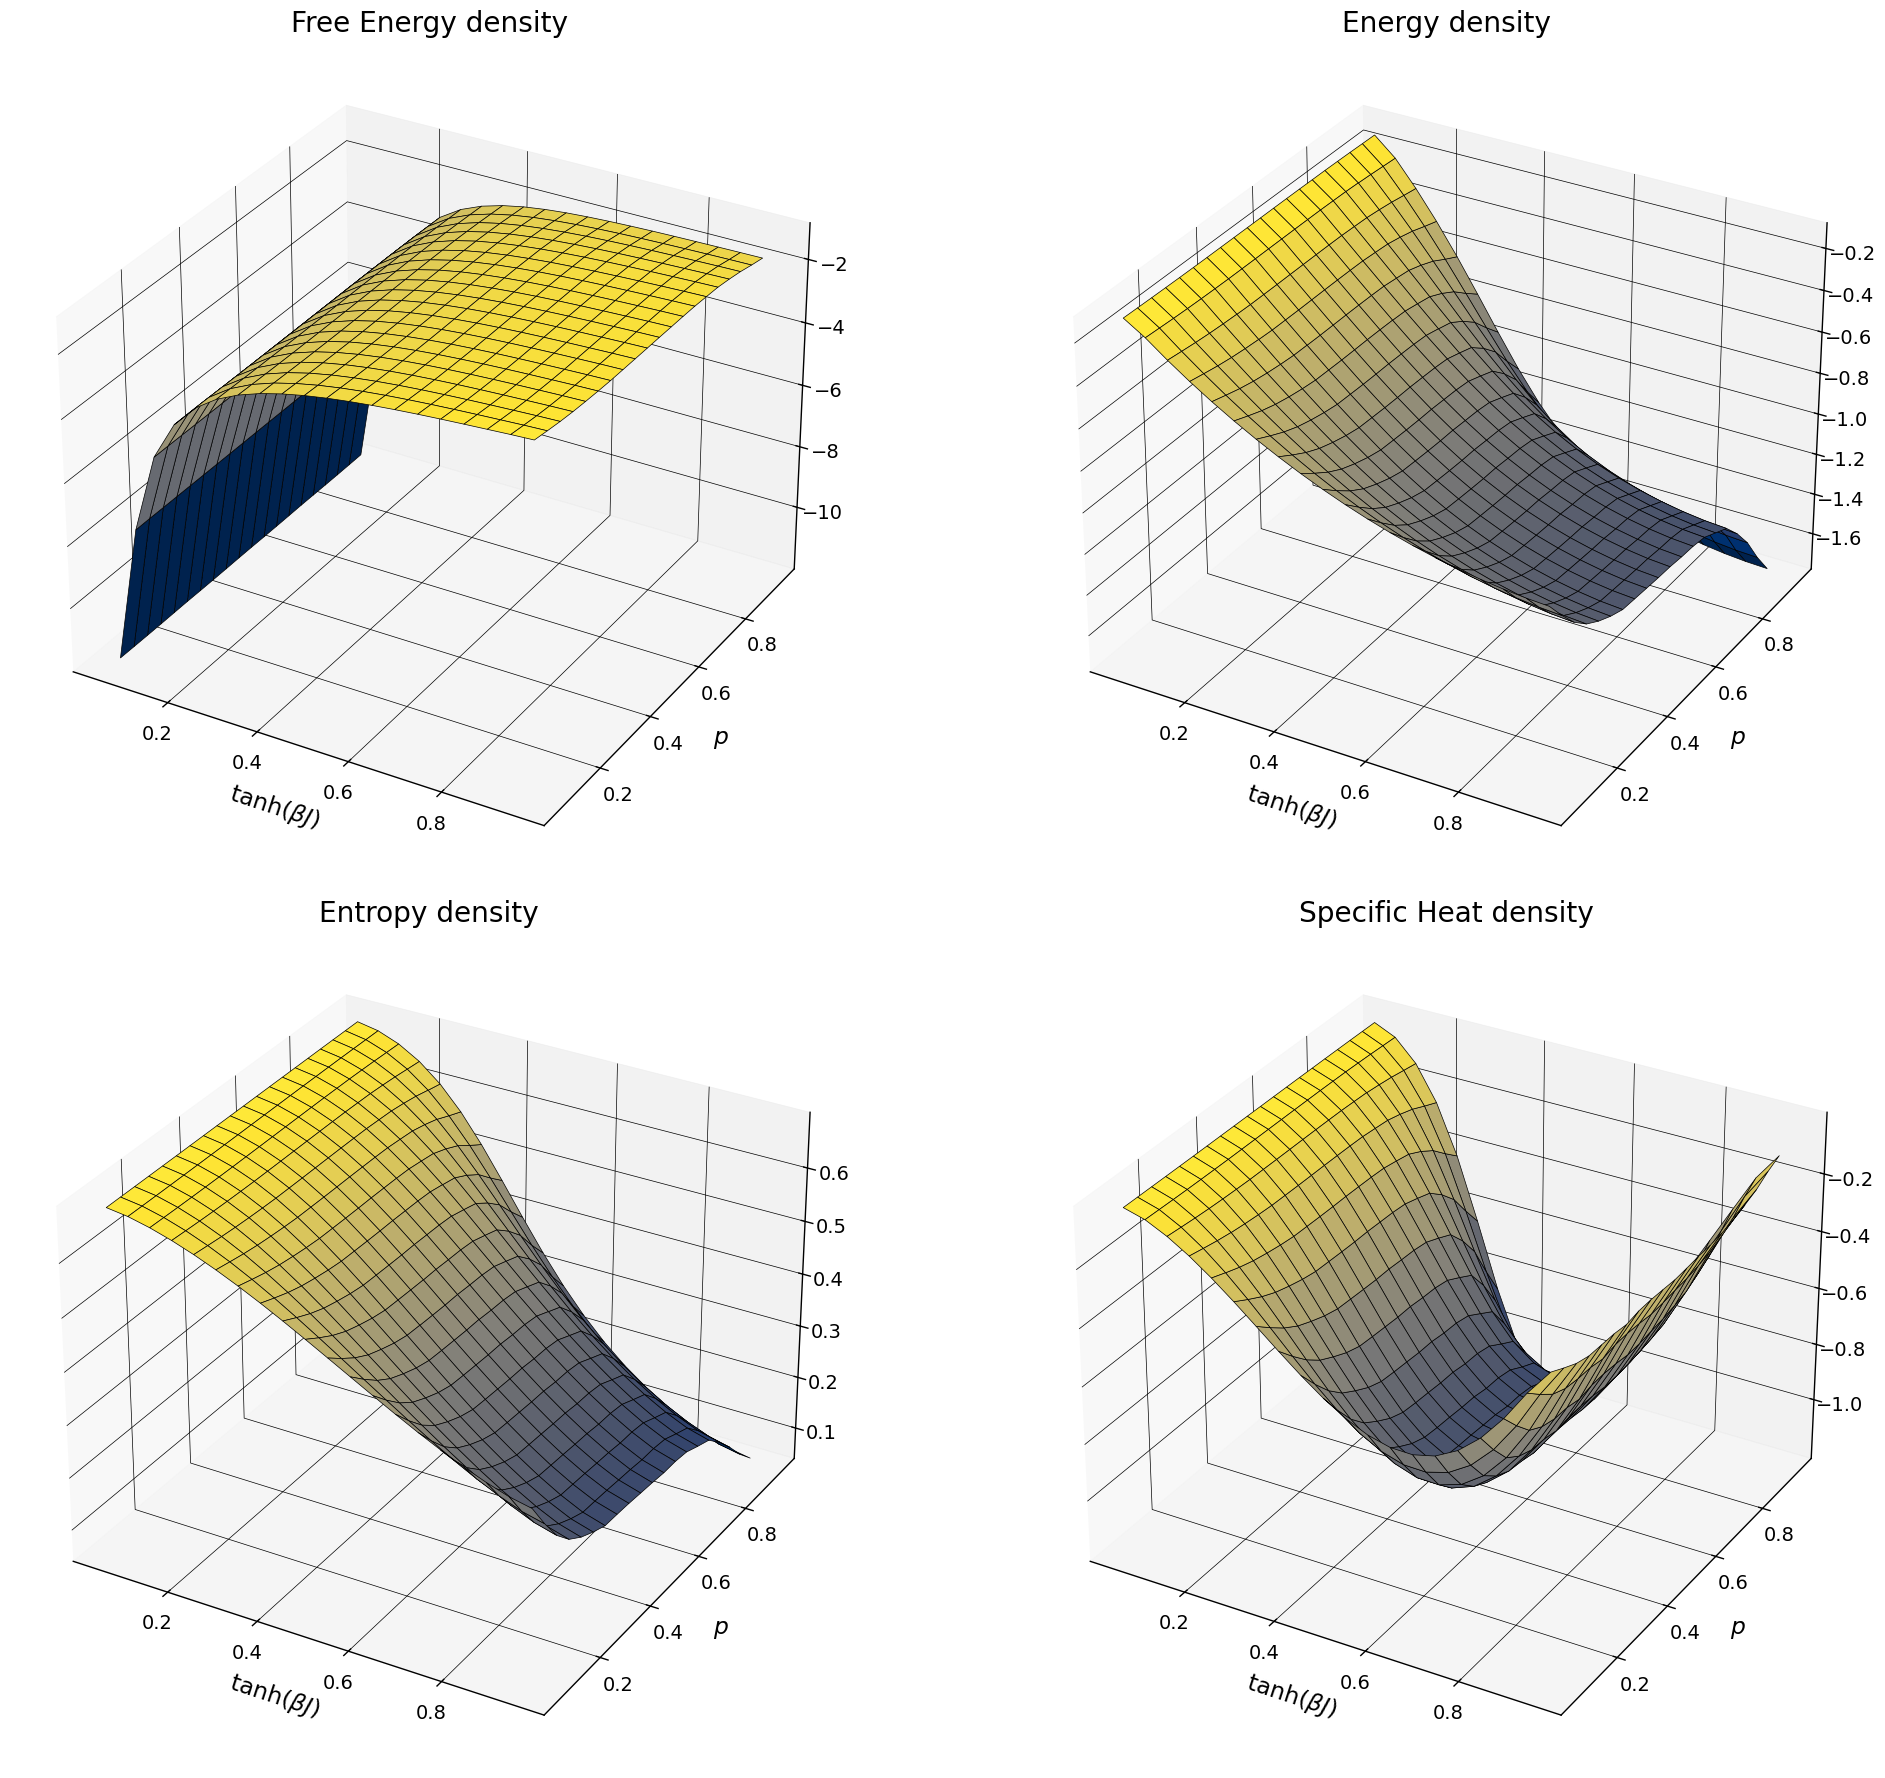

In [262]:
#cmap options
#['viridis', 'plasma', 'inferno', 'magma', 'cividis']

fig, ax = plt.subplots(2, 2, figsize=(2*11,2*9), subplot_kw=dict(projection='3d'))
ax = ax.flatten()
for i in range(4):
    
    ## grid/axis lines
    #ax[i].w_xaxis.gridlines.set_lw(3.0)
    #ax[i].w_yaxis.gridlines.set_lw(3.0)
    #ax[i].w_zaxis.gridlines.set_lw(3.0)
    #ax[i].w_xaxis.pane.set_color('black');
    #ax[i].w_yaxis.pane.set_color('black');
    #ax[i].w_zaxis.pane.set_color('black');
    #ax[i].w_xaxis.line.set_color('black');
    ax[i].xaxis._axinfo["grid"].update({"linewidth":0.5, 'color':'black'})
    ax[i].yaxis._axinfo["grid"].update({"linewidth":0.5, 'color':'black'})
    ax[i].zaxis._axinfo["grid"].update({"linewidth":0.5, 'color':'black'})

    ## plotting
    #ax.plot_surface(xi, yi, zi)
    #ax.contour3D(xi, yi, zi, 50, cmap='binary')
    ax[i].plot_surface(xi, yi, zi_list[i], rstride=1, cstride=1, cmap='cividis', edgecolor='black')
    #ax[i].plot_wireframe(xi, yi, zi_list[i], color='black', linewidth=0.5)
    ax[i].set_xlabel(r'$\tanh(\beta J)$', labelpad=10)
    ax[i].set_ylabel(r'$p$', labelpad=10)
    ax[i].set_title(title_list[i])    

plt.tight_layout()
plt.savefig('figures/disordered_model_thermodynamic_surfaceplots.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Make 2d contour plots:

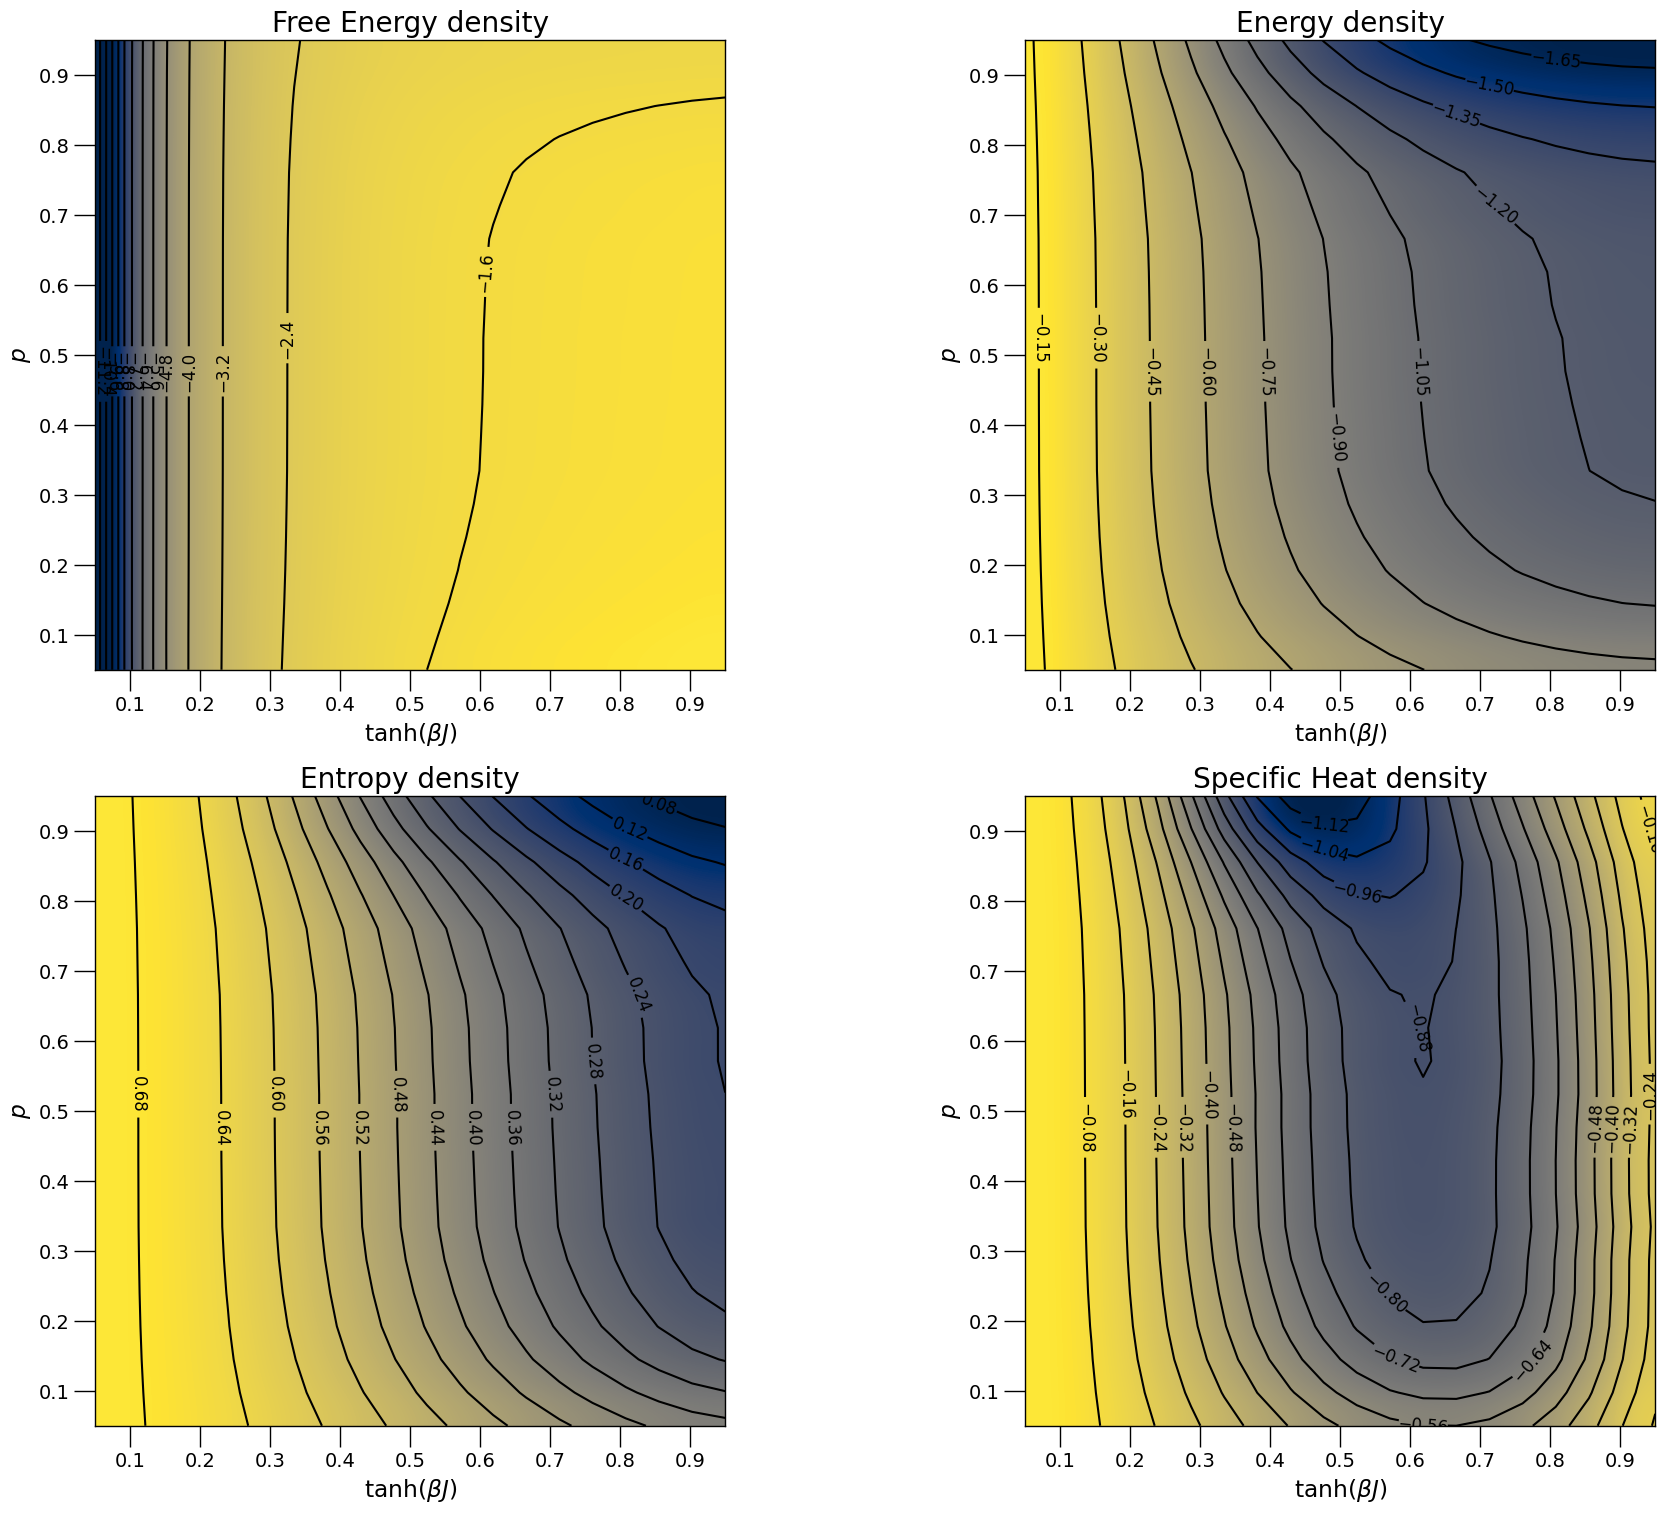

In [264]:
fig, ax = plt.subplots(2, 2, figsize=(2*11,2*9))
ax = ax.flatten()

for i in range(4):
    ax[i].imshow(zi_list[i], 
                 vmin=zi_list[i].min(), 
                 vmax=zi_list[i].max(), 
                 origin='lower', 
                 extent=[x.min(), x.max(), y.min(), y.max()], 
                 interpolation='spline16',
                 cmap='cividis')
    #ax[i].scatter(x, y, c=z_list[i], s=20)    
    contours = ax[i].contour(xi, yi, zi_list[i], 15, linestyles='-', colors='black')
    ax[i].clabel(contours, inline=True, fontsize=12)
    ax[i].set_xlabel(r'$\tanh(\beta J)$')
    ax[i].set_ylabel(r'$p$')
    ax[i].set_title(title_list[i])
    ax[i].grid(visible=None)
#plt.colorbar()
plt.tight_layout()
plt.savefig('figures/disordered_model_thermodynamic_contourplots.pdf', bbox_inches='tight', pad_inches=0)
plt.show()